#### Import packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from categories import *

#### Putting all train images into structured dataframe

In [3]:
train_test_df = pd.DataFrame(columns=['ID', 'Target'])

for (categories, code) in CATEGORIES_CODES.items():
    for img in os.listdir(f'data/train/{categories}'):
        train_test_df.loc[train_test_df.shape[0]] = [img, code]

train_test_df.to_csv('data/processed/train_test_set.csv', index=False)

#### Shuffling and splitting data between train and test sets

In [4]:
train_set = pd.DataFrame()
test_set = pd.DataFrame()

split = StratifiedShuffleSplit(n_splits=1, test_size=0.05)
for train_dataframe, test_dataframe in split.split(train_test_df, train_test_df[['Target']]):
    train_set = train_test_df.loc[train_dataframe]
    test_set = train_test_df.loc[test_dataframe]
    
train_set.to_csv('data/processed/train_set.csv', index=False)
test_set.to_csv('data/processed/test_set.csv', index=False)

#### Build a class for putting images and categories as labels from dataframes to numerical np. array

In [7]:
class DataLoader:
    
    def __init__(self, path: str) -> None:
        self.data = pd.read_csv(path)
        self.index = 0
        self.size = self.data.shape[0]
        self.image_shape = (224, 224, 1)
        
        self.images = np.empty((self.size,) + self.image_shape, dtype='float16')
        self.labels = np.empty(self.size, dtype='uint8')

    def load_data(self) -> None:
        for _id, _categories in self.data.values:
            self.add_image(_id, _categories)
    
    def add_image(self, path: str, category: int) -> None:
        image_path = f"data/train/{CATEGORIES_REVERSE[category]}/{path}"
        image = cv2.imread(image_path, 0)/255
        
        self.images[self.index] = np.asarray(image, dtype='float16').reshape(self.image_shape)
        self.labels[self.index] = category
        self.index += 1

        print(f"[+] Progress: {self.index}/{self.size}", end='\r')
        
        if self.index == self.size:
            self.labels = to_categorical(self.labels)
            print(f"\n[+] DONE")
    
    def show_image(self, index: int) -> None:
        plt.imshow(self.images[index], cmap='gray')

#### Loading train set

In [8]:
train_data = DataLoader('data/processed/train_set.csv')
train_data.load_data()

[+] Progress: 14629/14629
[+] DONE


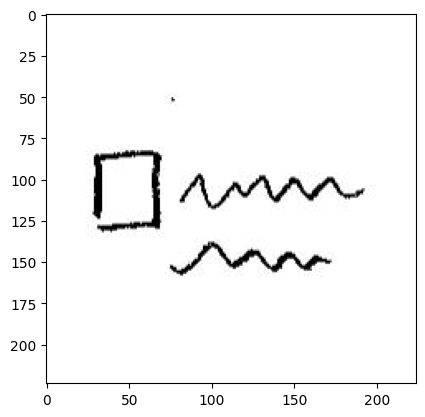

In [9]:
train_data.show_image(200)

#### Loading test set

In [10]:
test_data = DataLoader('data/processed/test_set.csv')
test_data.load_data()

[+] Progress: 770/770
[+] DONE


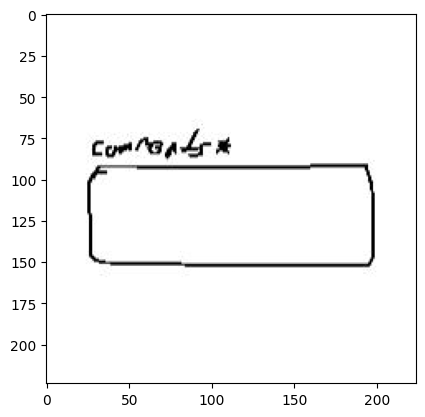

In [11]:
test_data.show_image(300)

#### Building Sketch Classificator Model as Tensorflow CNN and training it

In [23]:
model = models.Sequential(
    [        
        layers.Conv2D(filters=32,kernel_size=(6,6), activation='relu', input_shape=train_data.image_shape),
        layers.MaxPooling2D(pool_size=(4,4)),

        layers.Conv2D(filters=64,kernel_size=(6,6), activation='relu'),
        layers.MaxPooling2D(pool_size=(4,4)),
        layers.Dropout(0.25),

        layers.Conv2D(filters=128,kernel_size=(6,6), activation='relu'),
        layers.MaxPooling2D(pool_size=(4,4)),
        layers.Dropout(0.25),
        
        layers.Flatten(),
        layers.Dense(128, activation='relu'),
        layers.Dropout(0.25),
        layers.Dense(len(CATEGORIES_CODES), activation='softmax')
    ]
)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(train_data.images, train_data.labels, epochs=30, batch_size=64, validation_split=0.05)

Epoch 1/30
218/218 [==============================] - 199s 908ms/step - loss: 2.3104 - accuracy: 0.2873 - val_loss: 1.6695 - val_accuracy: 0.4740
Epoch 2/30
218/218 [==============================] - 206s 945ms/step - loss: 1.6162 - accuracy: 0.5044 - val_loss: 1.3638 - val_accuracy: 0.6011
Epoch 3/30
218/218 [==============================] - 217s 994ms/step - loss: 1.3963 - accuracy: 0.5765 - val_loss: 1.1570 - val_accuracy: 0.6434
Epoch 4/30
218/218 [==============================] - 212s 973ms/step - loss: 1.2496 - accuracy: 0.6143 - val_loss: 1.1091 - val_accuracy: 0.6803
Epoch 5/30
218/218 [==============================] - 211s 967ms/step - loss: 1.1500 - accuracy: 0.6475 - val_loss: 1.0332 - val_accuracy: 0.6858
Epoch 6/30
218/218 [==============================] - 214s 983ms/step - loss: 1.0557 - accuracy: 0.6727 - val_loss: 0.9967 - val_accuracy: 0.7008
Epoch 7/30
218/218 [==============================] - 212s 974ms/step - loss: 0.9977 - accuracy: 0.6904 - val_loss: 0.9414 -

### Plotting metrics

[Text(0.5, 0, 'Epoch'), Text(0, 0.5, 'Accuracy')]

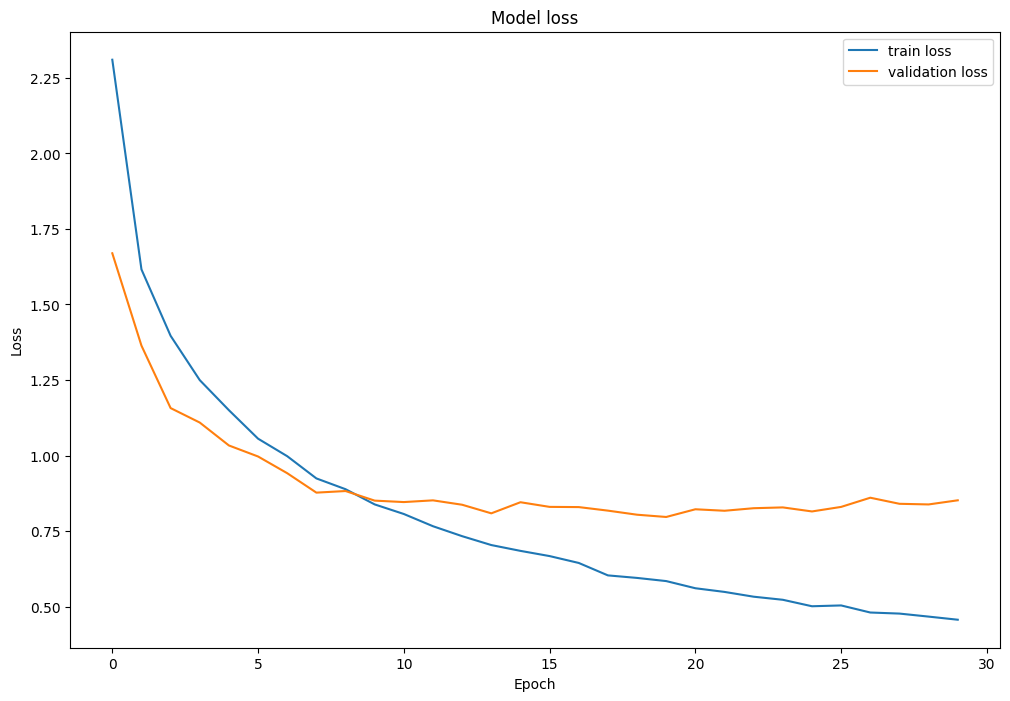

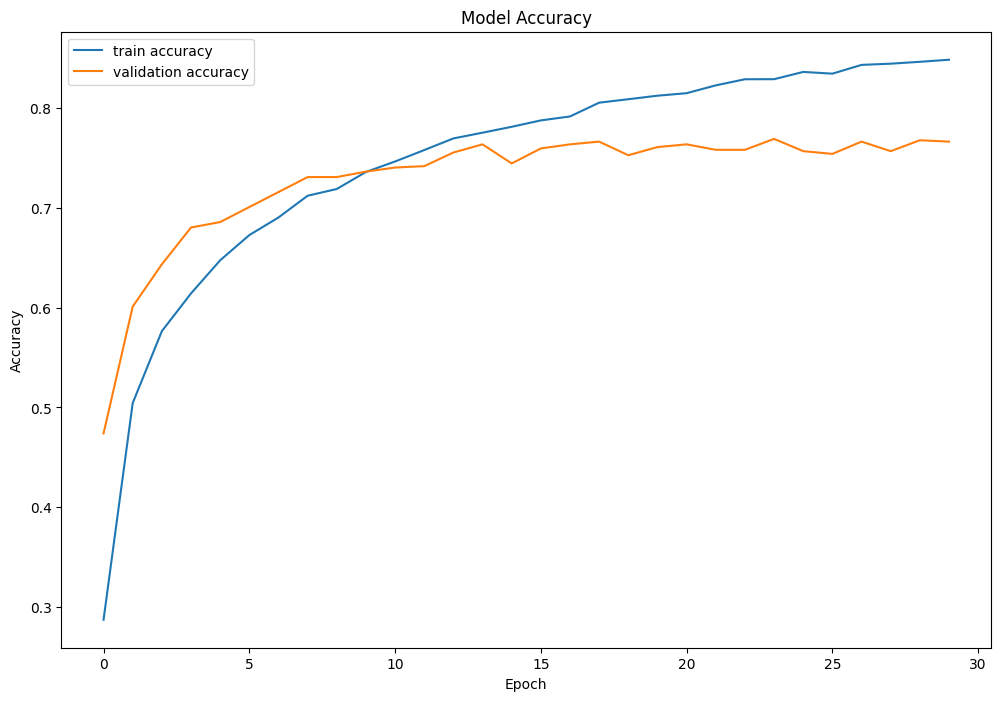

In [24]:
metrics = pd.DataFrame(history.history)
metrics.rename(columns={'loss':'train loss','val_loss':'validation loss', 
                        'accuracy':'train accuracy','val_accuracy':'validation accuracy'},inplace=True)

metrics[['train loss', 'validation loss']].plot(title='Model loss',figsize=(12,8)).set(xlabel='Epoch',ylabel='Loss')
metrics[['train accuracy', 'validation accuracy']].plot(title='Model Accuracy',figsize=(12,8)).set(xlabel='Epoch',ylabel='Accuracy')

#### Evaluation the model

In [25]:
model.evaluate(test_data.images, test_data.labels)

25/25 [==============================] - 3s 127ms/step - loss: 0.8471 - accuracy: 0.7610


[0.8470652103424072, 0.7610389590263367]

#### Making a predictions with final submission test images and converting it to structured dataframe

In [26]:
predictions = pd.DataFrame(columns=['ID', 'Target'])

img_list = os.listdir('data/test')
image_shape = (224, 224, 1)

prediction_images = np.empty((_s:=len(img_list), ) + image_shape, dtype='float16')

print(f'Start predicting...')
for i, _img in enumerate(img_list):
    prediction_image = cv2.imread(f"data/test/{_img}", 0)/255
    prediction_images[i] = np.asarray(prediction_image, dtype='float16').reshape(image_shape)
    
for i, p in enumerate(model.predict(prediction_images)):
    predictions.loc[i] = [img_list[i], CATEGORIES_REVERSE[np.argmax(p)]]
print("[+] Done")

Start predicting...
161/161 [==============================] - 21s 132ms/step
[+] Done


#### Showing prediction

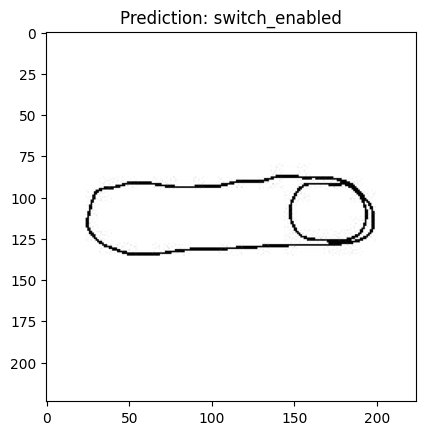

In [27]:
plt_img_index = 10
plt.title(f"Prediction: {predictions['Target'][plt_img_index]}")
plt.imshow(prediction_images[plt_img_index], cmap='gray')

#### Saving all predictions to csv

In [28]:
predictions.to_csv(f'data/result/predictions.csv', index=False)